In [ ]:
#| default_exp modified_efficient_importance_sampling\
import jax
jax.config.update("jax_enable_x64", True)

# Modified Efficient Importance Sampling

Modified efficient importance sampling is used to improve on mode estimation. The goal is to minimize the variance of log-weights in importance sampling [@Zhang2007Efficient,@Koopman2019Modified]. If the importance sampling model is a gaussian one where observations are conditionally independent across time and space, its iterations reduce to a least squares problem which can be solved efficiently.

$$
\int \left(\log p (y | x) - \log g(y|x) - \lambda \right)^2 \log p(x|y) \mathrm d x
$$
where $\lambda = \mathbf E \left(\log p(y|x) - \log g(z|x)| Y = y\right)$. This is approximated by an importance sampling version 

$$
\sum_{i = 1}^N \left(\log p(y|X^i) - \log g(z|X^i) - \lambda\right) w(X^i).
$$

Using gaussian proposals $g$ we have for signals $S_t = B_t X_t$

$$
\begin{align*}
\log g(z_{t}|s_{t}) &= -\frac{1}{2} (z_{t} - s_{t})^T\Omega^{-1}_{t}(z_{t} - s_{t}) - \frac{p}{2} \log (2\pi) - \frac{1}{2} \log \det \Omega_{t}.
\end{align*}
$$
where $\Omega_t = \operatorname{diag} \left( \omega_{t,1}, \dots, \omega_{t,p}\right)$.



Due to the large dimension of the problem we solve it for each $t$ separately

$$
\begin{align*}
\sum_{i = 1}^N(\log p(y_t|s_t^{i}) - \log g(z_{t}| s_t^{i}) - \lambda_{t})^2 w(s_t^i) &= \sum_{i = 1}^N\left(\log p(y_t|s_t^{i}) +\frac{1}{2} (z_{t} - s_{t}^{i})^T\Omega^{-1}_{t}(z_{t} - s_{t}^{i}) + \frac{p}{2} \log (2\pi) + \frac{1}{2} \log \det \Omega_{t} - \lambda_{t}\right)^2 w(s_t^i) 
%&=  \sum_{i = 1}^{N}(\log p(y_t|s_t^{i}) - (- 2 \Omega_t ^{-1}z_t)^{T} s^{i}_t -  (s^{i}_t)^T\Omega_t^{-1}s^{i}_t - \lambda_t - C_t)^2w(s_t^i) \\
%&= \sum_{i = 1}^N \left(\log p(y_t|s_t^{i}) - (s^{i}_t)^{T}(- 2 \Omega_t ^{-1}z_t) + \frac{1}{2} \sum_{j = 1}^{p} (s^{i}_{t,j})^{2} \frac{1}{\omega_{t,j}} - \lambda_t - C_t \right)
\end{align*}
$$

and minimized over the unknown parameters $\left(z_t, \Omega_t, \lambda_t - C_t\right)$, which is a weighted least squares setting with "observations" $\log p(y_t|s_t)$.

To perform the estimation memory efficient, we combine the FFBS algorithm (see [00_glssm.ipynb]) with the optimization procedure, so the memory requirement of this algorithm is $\mathcal O(N)$ instead of $\mathcal O(N\cdot n)$.

<!--
At time $t$ the problem can be formulated as the following constrained linear least squares problem:

$$
\begin{align*}
    \min_{x} (y - Ax)^{T} W (y - Ax) &= x^{T}A^{T}W Ax - 2 y^{T} W Ax + y^{T}Wy= \frac{1}{2} x^{T}Qx + c^Tx + y^{T}Wy \\
    \text{subject to ~ ~ ~ ~ ~} & l \leq x \leq u
\end{align*}
$$
where
$$
\begin{align*}
    y &=  \left(\log p(y_{t}| s_{y}^{1}), \dots, \log p(y_{t}|s_{t}^N)\right)^{T} &\in \mathbf{R}^{N}\\
    A &= \left( \mathbf 1_{(N, 1)}, S, -\frac{1}{2} S^{2}  \right) &\in \mathbf{R}^{N \times (2p + 1)}\\
    S = (S_{i,j}) &= s_{t,j}^i &\in \mathbf{R}^{N \times p}\\
    x &= \left(C_{t}, \frac{z_{t}^{1}}{\omega_{t}^1}, \dots, \frac{z_{t}^p}{\omega_{t}^p}, \frac{1}{\omega_{t}^1}, \dots, \frac{1}{\omega_{t}^p}\right) &\in \mathbf{R}^{2p + 1}\\
    C_{t} &= \lambda_{t} - \frac{1}{2}\log\det \Omega_{t} - \frac{p}{2}\log(2\pi) - \frac{1}{2} z_{t}^T\Omega_{t}^{-1}z_{t} &\in \mathbf{R}\\
    W &= \operatorname{diag} \left( w(s_{t}^1), \dots, w(s_{t}^N)\right) &\in \mathbf{R}^{N\times N}\\
    Q &= 2 A^{T}W A  &\in \mathbf{R}^{(2p + 1) \times (2p + 1)}\\
    c &= - 2 A^{T}Wy &\in \mathbf{R}^{2p+1}
\end{align*}
$$
-->

In [ ]:
# | export
import jax.numpy as jnp
import jax.random as jrn
from jaxtyping import Float, Array, PRNGKeyArray
from jax import vmap
from isssm.util import converged
from isssm.importance_sampling import log_weights_t, normalize_weights
from functools import partial
from jax.lax import while_loop
from isssm.kalman import kalman
from jax.lax import scan
from isssm.util import MVN_degenerate as MVN

from isssm.glssm import vmatmul
from isssm.typing import GLSSM, PGSSM

def modified_efficient_importance_sampling(
    y: Float[Array, "n+1 p"], # observations
    model: PGSSM, # model
    z_init: Float[Array, "n+1 p"], # initial z estimate
    Omega_init: Float[Array, "n+1 p p"], # initial Omega estimate
    n_iter: int, # number of iterations
    N: int, # number of samples
    key: PRNGKeyArray, # random key
    eps: Float = 1e-5, # convergence threshold
):
    np1, p = y.shape
    x0, A, Sigma, B, dist, xi = model
    n = np1 - 1

    lw_t = vmap(lambda s, y, xi, z, Omega: log_weights_t(s, y, xi, dist, z, Omega))

    vB = vmap(partial(vmap(jnp.matmul), B))
    v_norm_w = vmap(normalize_weights)

    def _break(val):
        a, i, z, Omega, z_old, Omega_old, key = val

        z_converged = converged(z, z_old, eps)
        Omega_converged = converged(Omega, Omega_old, eps)
        iteration_limit_reached = i >= n_iter

        return jnp.logical_or(
            jnp.logical_and(z_converged, Omega_converged), iteration_limit_reached
        )

    def _iteration(val):
        a, i, z, Omega, _, _, initial_key = val

        x_filt, Xi_filt, x_pred, Xi_pred = kalman(z, GLSSM(x0, A, Sigma, B, Omega))

        key, subkey = jrn.split(initial_key)
        last_samples = MVN(x_filt[-1], Xi_filt[-1]).sample(N, seed=subkey)

        def optimal_parameters(signal: Float[Array, "N p"], weights: Float[Array, "N"], log_p: Float[Array, "N"]):
            ones = jnp.ones_like(weights)[:,None]
            w_inner_prod = lambda a, b: jnp.einsum('i,ij,ik->jk',weights, a, b)
            
            X_T_W_X = jnp.block([
                [w_inner_prod(ones, ones), w_inner_prod(ones, signal), w_inner_prod(ones, -.5 * signal**2)],
                [w_inner_prod(signal, ones), w_inner_prod(signal, signal), w_inner_prod(signal, -.5 * signal**2)],
                [w_inner_prod(-.5 * signal**2, ones), w_inner_prod(-.5 * signal**2, signal), w_inner_prod(-.5 * signal**2, -.5 * signal**2)]
            ])
            X_T_W_y = jnp.concatenate([
                w_inner_prod(ones, log_p[:,None]), w_inner_prod(signal, log_p[:, None]), w_inner_prod(-.5 * signal**2, log_p[:, None])
            ])
            
            return jnp.linalg.solve(X_T_W_X, X_T_W_y[:,0])

        def eis_parameters(B_t, xi_t, y_t, z_t, Omega_t, samples):
            signal_t = vmatmul(B_t, samples)
            log_p_t = dist(signal_t, xi_t).log_prob(y_t).sum(axis=-1)
            log_w_t = vmap(lambda s_t: log_weights_t(s_t, y_t, xi_t, dist, z_t, Omega_t))(signal_t)
            w_t_norm = normalize_weights(log_w_t)

            beta_t = optimal_parameters(signal_t, w_t_norm, log_p_t)
            return beta_t

        def sample_and_estimate(carry, inputs):
            previous_samples, key = carry
            x_filt_t, Xi_filt_t, Xi_pred_t, A_t, B_t, xi_t, y_t, z_t, Omega_t = inputs

            # sampling
            G_t = Xi_filt_t @ jnp.linalg.solve(Xi_pred_t, A_t).T

            cond_expectation = x_filt_t + vmatmul(G_t, previous_samples - (A_t @ x_filt_t)[None])
            cond_covariance = Xi_filt_t - G_t @ Xi_pred_t @ G_t.T

            key, subkey = jrn.split(key)
            new_samples = MVN(cond_expectation, cond_covariance).sample(seed=subkey)

            # estimation 
            beta_t = eis_parameters(B_t, xi_t, y_t, z_t, Omega_t, new_samples)

            return (new_samples, key), beta_t

        wls_estimate_n = eis_parameters(B[-1], xi[-1], y[-1], z[-1], Omega[-1], last_samples)
            
        key, subkey = jrn.split(key)
        _, wls_estimate = scan(
            sample_and_estimate,
            (last_samples, subkey),
            (x_filt[:-1], Xi_filt[:-1], Xi_pred[1:], A, B[:-1], xi[:-1], y[:-1], z[:-1], Omega[:-1]),
            reverse=True
        )
        wls_estimate = jnp.concatenate([wls_estimate, wls_estimate_n[None]])

        a = wls_estimate[:, 0]
        b = wls_estimate[:, 1 : (p + 1)]
        c = wls_estimate[:, (p + 1) :]

        z_new = b / c
        Omega_new = vmap(jnp.diag)(1 / c)


        return a, i+1, z_new, Omega_new, z, Omega, initial_key

    key, subkey = jrn.split(key)
    init = _iteration(
        (jnp.zeros(np1), 0, z_init, Omega_init, None, None, subkey)
    )

    _keep_going = lambda *args: jnp.logical_not(_break(*args))

    _, n_iters, z, Omega, _, _, _ = while_loop(
        _keep_going, _iteration, init
    )

    return z, Omega

In [ ]:
from isssm.importance_sampling import log_weights
from isssm.lcssm import  simulate_lcssm, nb_pgssm_runnning_example
from isssm.kalman import FFBS
from isssm.kalman import kalman, smoother
import jax.random as jrn
from isssm.mode_estimation import mode_estimation
import jax.numpy as jnp
from jax import vmap
from functools import partial
import matplotlib.pyplot as plt
from isssm.importance_sampling import ess_lw
from isssm.typing import PGSSM

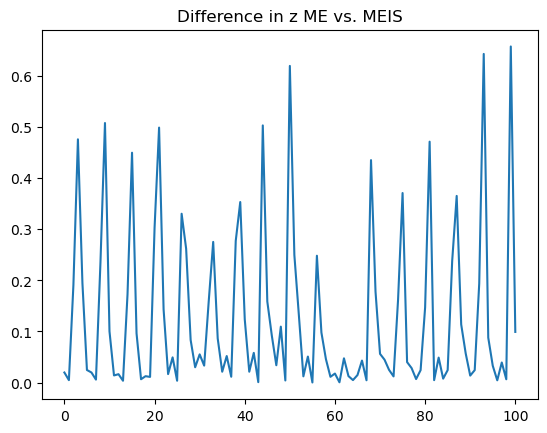

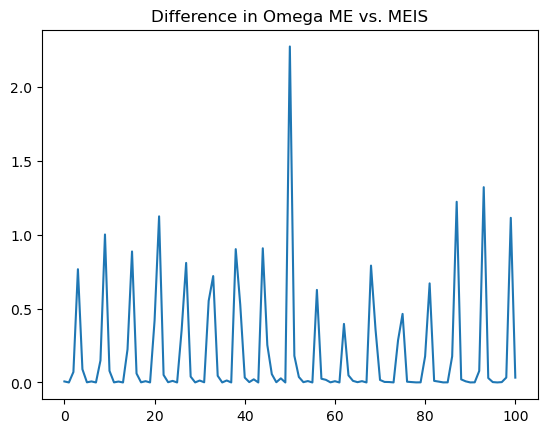

In [ ]:
key = jrn.PRNGKey(512)
key, subkey = jrn.split(key)
model = nb_pgssm_runnning_example()
(x, ), (y,) = simulate_lcssm(model, 1, subkey)
s_init = jnp.log(y + 1.)
x_smooth, z, Omega = mode_estimation(y, model, s_init, 10)

N = int(1e5)
key, subkey = jrn.split(key)
z_meis, Omega_meis = modified_efficient_importance_sampling(
    y, model, z, Omega, 10, N, subkey
)

z_diff = ((z_meis - z)**2).mean(axis=1)
plt.title("Difference in z ME vs. MEIS")
plt.plot(z_diff)
plt.show()

Omega_diff = ((Omega_meis - Omega)**2).mean(axis=(1,2))
plt.title("Difference in Omega ME vs. MEIS")
plt.plot(Omega_diff)
plt.show()

In [ ]:
from isssm.importance_sampling import lcssm_importance_sampling
from isssm.importance_sampling import ess_pct

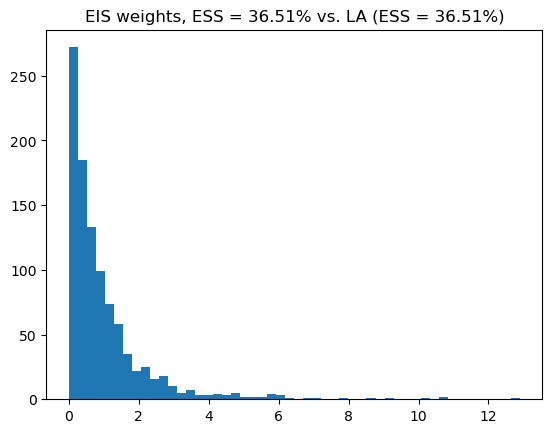

In [ ]:
N = 1000
_, lw_la = lcssm_importance_sampling(y, model, z, Omega, N, jrn.PRNGKey(423423))
samples, lw = lcssm_importance_sampling(y, model, z_meis, Omega_meis, N, jrn.PRNGKey(423423))
weights = normalize_weights(lw)
plt.title(f"EIS weights, ESS = {ess_lw(lw) / lw.shape[0] * 100:.2f}% vs. LA (ESS = {ess_pct(lw):.2f}%)")
plt.hist(N*weights[None,:], bins=50)
plt.show()

EIS increases ESS of importance sampling from LA.

In [ ]:
#| hide
import nbdev; nbdev.nbdev_export()